Loading model: E:\12_AnomalyDetection\0_AUTOENCODER\checkpoints/checkpoints_smooth_upsample_RUG-STAINS\autoencoder_epoch_40.pth into smooth_upsample
Loaded checkpoint from epoch 40 with loss: 0.2740


(-0.5, 9755.5, 389.5, -0.5)

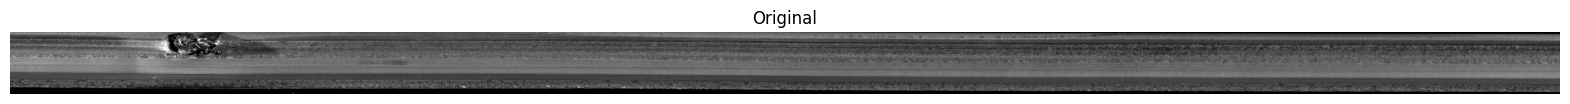

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import torchvision.transforms as transforms
from AE_anomalyboxing import load_model, preprocess_image, compute_anomaly_map, detect_defects, create_visualizations, save_results, denormalize
from models import UNet_BackgroundAware, UNet_AnomalyDetection, UNet_DetailPreserving, Autoencoder_smooth_upsample

# Load the saved absolute difference image (in grayscale)
img_path = r"E:\12_AnomalyDetection\0_AUTOENCODER\test_imgs\221013_0912320_00022_2_0.jpg"
base_name = os.path.basename(img_path)
model = load_model(r"E:\12_AnomalyDetection\0_AUTOENCODER\checkpoints/checkpoints_smooth_upsample_RUG-STAINS\autoencoder_epoch_40.pth",'smooth_upsample')
# orig_img_path = os.path.join(r"E:\12_AnomalyDetection\test_imgs", base_name)
# print(orig_img_path)

pil_image = Image.open(img_path).convert("L")
np_img = np.array(pil_image)
# img_orig = img_orig.astype(np.uint8)

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')


torch.Size([1, 1, 256, 2048]) (390, 9756)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.1920929e-07..1.5499833].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.454062e-05..1.5499736].


float32 float32
(256, 2048)
(390, 9756)
(390, 9756)
(256, 2048, 3)
(256, 2048)


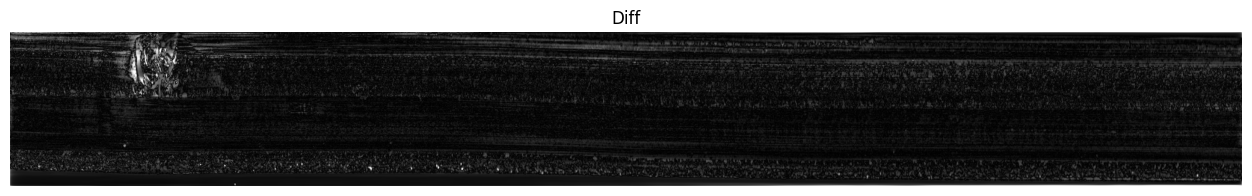

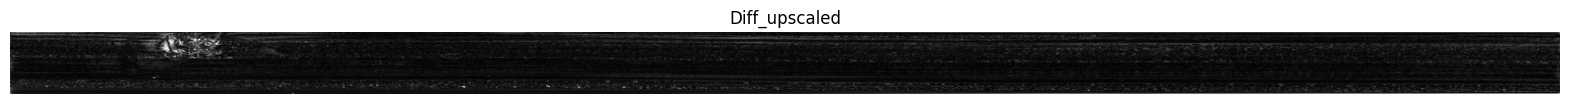

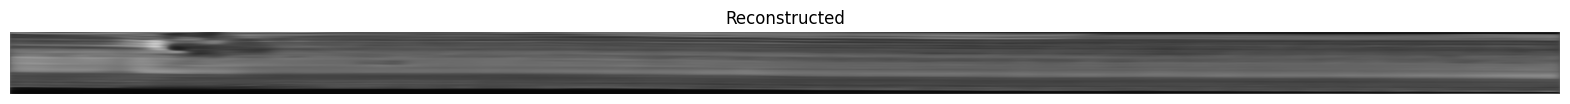

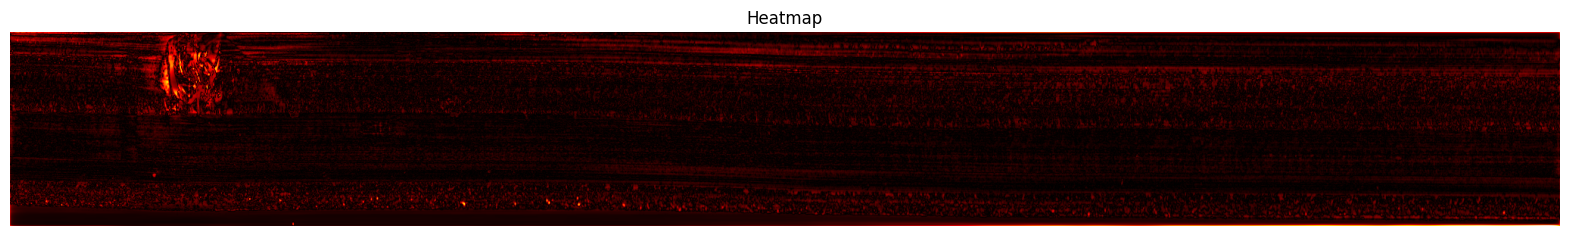

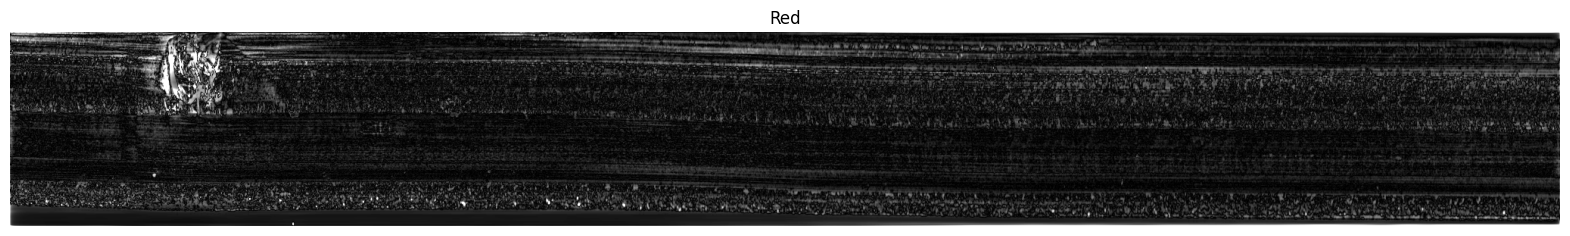

In [50]:
target_size=(256, 2048)

transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # maps [0,1] to [-1,1]
    ])

original_shape = np_img.shape
img_tensor = transform(pil_image).unsqueeze(0)
print(img_tensor.shape, original_shape)
reconstructed = model(img_tensor)

original_resized = denormalize(img_tensor.cpu()[0, 0]).detach().numpy()
reconstructed_img = denormalize(reconstructed.cpu()[0, 0]).detach().numpy()
print(original_resized.dtype, reconstructed_img.dtype)

# Compute the absolute difference at the resized resolution (exactly like inference.py)
diff = np.abs((original_resized - reconstructed_img) * 2)


# Create a heatmap of the difference
diff_norm = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
diff_norm = diff_norm.astype(np.uint8)
heatmap_img = cv2.applyColorMap(diff_norm, cv2.COLORMAP_HOT)
red = heatmap_img[:, :, 2]  # Red channel

orig_h, orig_w = original_shape
diff_upscaled = cv2.resize(diff, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)
reconstructed_img_upscaled = cv2.resize(reconstructed_img, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(28, 2))
plt.imshow(cv2.cvtColor(diff, cv2.COLOR_BGR2RGB))
plt.title("Diff")
plt.axis('off')
print(diff.shape)

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(diff_upscaled, cv2.COLOR_BGR2RGB))
plt.title("Diff_upscaled")
plt.axis('off')
print(diff_upscaled.shape)

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(reconstructed_img_upscaled, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed")
plt.axis('off')
print(reconstructed_img_upscaled.shape)

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
plt.title("Heatmap")
plt.axis('off')
print(heatmap_img.shape)

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(red, cv2.COLOR_BGR2RGB))
plt.title("Red")
plt.axis('off')
print(red.shape)




#### Lines and blobs detector

(-0.5, 2047.5, 255.5, -0.5)

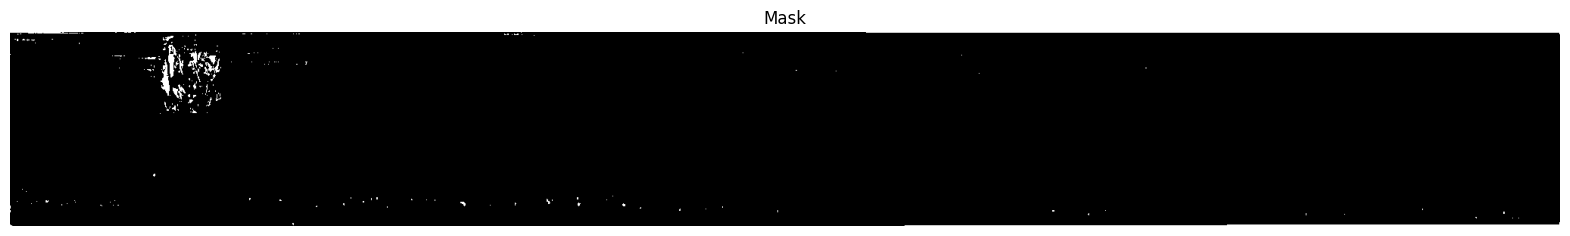

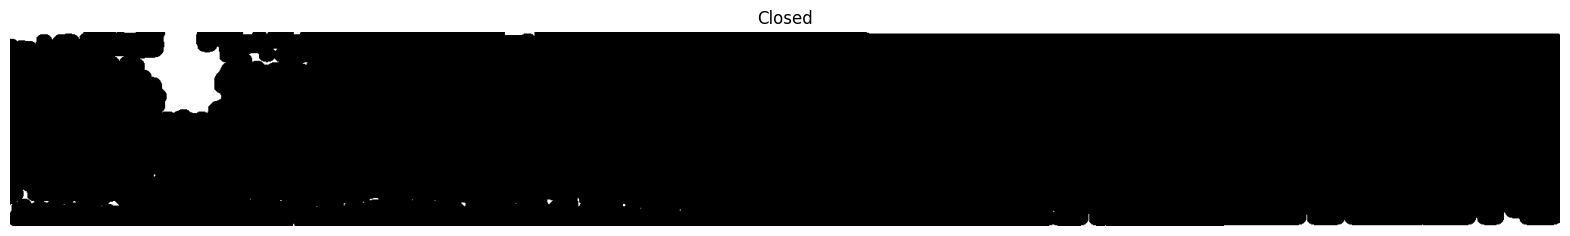

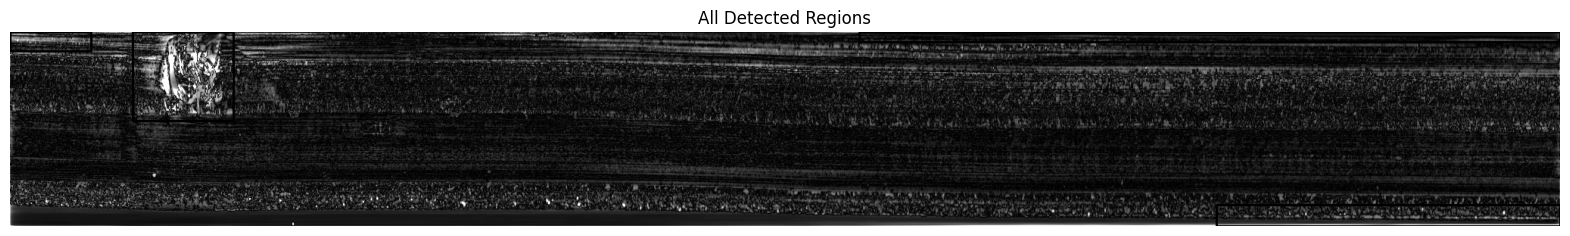

In [55]:
area_thresh            = 200 # The minimum area of the defect to be considered
merge_kernel_size      = (20, 20) # The size of the kernel for merging nearby regions
crop_padding           = 10 # The padding for the cropped region
"""
Crop line-like and blob-like regions from a heatmap image, merging nearby regions
and filtering by area.
"""

h_img, w_img = red.shape[:2]
# Threshold calculation
p = 95
  # e.g. top 1% of red pixels
th = np.percentile(red.flatten(), p)


# 1) Threshold → binary mask
_, mask = cv2.threshold(red, 180, 255, cv2.THRESH_BINARY)


# 2) Close small gaps
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, merge_kernel_size)
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 3) Find contours
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ——— Plot #1: all contours in green with padding ———
img_all = red.copy()
boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if cv2.contourArea(cnt) < area_thresh:
        continue

    boxes.append((x, y, w, h))
    # apply padding, but don’t go out of image bounds
    x0 = max(x - crop_padding, 0)
    y0 = max(y - crop_padding, 0)
    x1 = min(x + w + crop_padding, w_img)
    y1 = min(y + h + crop_padding, h_img)

    cv2.rectangle(img_all, (x0, y0), (x1, y1), (0, 255, 0), 2)  # green

# plot the mask and the contours
plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Mask")
plt.axis('off')

# plt.figure(figsize=(20, 4))
# plt.imshow(cv2.cvtColor(kernel, cv2.COLOR_BGR2RGB))
# plt.title("Kernel")
# plt.axis('off')

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(closed, cv2.COLOR_BGR2RGB))
plt.title("Closed")
plt.axis('off')

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB))
plt.title("All Detected Regions")
plt.axis('off')

[[0], [1], [2, 3]]
[(1604, 238, 444, 18), (1132, 0, 916, 3), (0, 0, 285, 107)]


(-0.5, 2047.5, 255.5, -0.5)

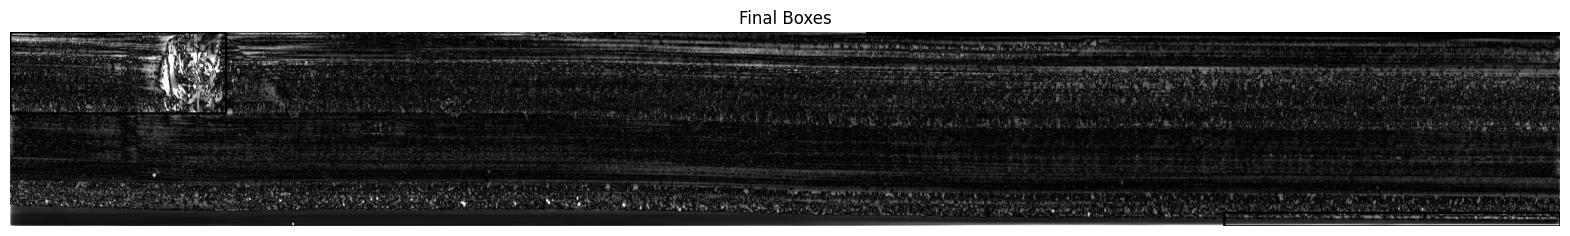

In [58]:
from functions import group_nearby_boxes, merge_grouped_boxes, group_and_merge_boxes


final_boxes = group_and_merge_boxes(boxes, x_distance_threshold=100, y_distance_threshold=10, overlap_threshold=0.0)
print(final_boxes)
# Plot the final boxes
img_merged = red.copy()

for box in final_boxes:
    x, y, w, h = box
    cv2.rectangle(img_merged, (x, y), (x + w, y + h), (0, 255, 0), 2)
plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(img_merged, cv2.COLOR_BGR2RGB))
plt.title("Final Boxes")
plt.axis('off')








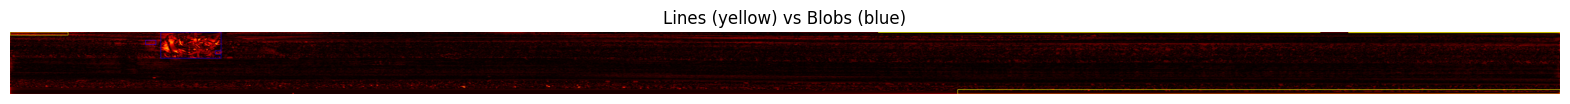

In [30]:
#  ——— Plot #2: lines in yellow, blobs in blue ———
img_class = np_img.copy()
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < area_thresh:
        continue
    
    x, y, w, h = cv2.boundingRect(cnt)
    ar = w / float(h + 1e-8)
    
    color = (0, 0, 255) if (ar > aspect_ratio_thresh or ar < 1/aspect_ratio_thresh) else (255, 255, 0)
    # OpenCV uses BGR, so (0,0,255)=red, (255,255,0)=cyan; swap to get yellow/blue:
    # yellow = (0,255,255), blue = (255,0,0)
    if ar > aspect_ratio_thresh or ar < 1/aspect_ratio_thresh:
        color = (0, 255, 255)  # yellow for lines
    else:
        color = (255, 0, 0)    # blue for blobs

    cv2.rectangle(img_class, (x, y), (x+w, y+h), color, 2)

plt.figure(figsize=(20, 3))
plt.imshow(cv2.cvtColor(img_class, cv2.COLOR_BGR2RGB))
plt.title("Lines (yellow) vs Blobs (blue)")
plt.axis('off')

plt.show()

In [21]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from models import UNet_BackgroundAware, UNet_AnomalyDetection, UNet_DetailPreserving, Autoencoder_smooth_upsample
from functions import group_and_merge_boxes
import argparse

def load_model(model_path, model_type='background_aware'):
    
    print(f"Loading model: {model_path} into {model_type}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    """Load the trained autoencoder model"""
    if model_type == 'background_aware':
        model = UNet_BackgroundAware()
    elif model_type == 'anomaly_detection':
        model = UNet_AnomalyDetection()
    elif model_type == 'detail_preserving':
        model = UNet_DetailPreserving()
    elif model_type == 'smooth_upsample':
        model = Autoencoder_smooth_upsample()
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Load checkpoint with backward compatibility
    checkpoint = torch.load(model_path, map_location=device)
    
    # Check if checkpoint is in new format (dict with keys) or old format (state_dict only)
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # New format: full checkpoint with optimizer state
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss: {checkpoint['loss']:.4f}")
    else:
        # Old format: just model state dict (OrderedDict)
        model.load_state_dict(checkpoint)
        print("Loaded checkpoint (old format)")

    model.eval()
    return model

def preprocess_image(image_path, target_size=(256, 2048)):
    """Load and preprocess image for the model"""
    # Load image using PIL to match the original inference code
    from PIL import Image
    import torchvision.transforms as transforms
    
    # Load the full-resolution image in grayscale
    pil_image = Image.open(image_path).convert("L")
    original_full = np.array(pil_image)  # Preserve the original size
    
    # Define the transform for model input: resize to (256, 2048), convert to tensor, and normalize to [-1, 1]
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # maps [0,1] to [-1,1]
    ])
    
    # Apply transform
    img_tensor = transform(pil_image).unsqueeze(0)  # (1, 1, 256, 2048)
    
    return img_tensor, original_full

def denormalize(t):
    """Denormalizes tensor from [-1, 1] to [0, 1]."""
    return t * 0.5 + 0.5

def compute_anomaly_map(model, img_tensor, original_shape):
    """Compute the anomaly map using the autoencoder - matches inference.py exactly"""
    with torch.no_grad():
        # Get reconstruction
        reconstructed = model(img_tensor)
        
        # Get the resized images (model input resolution)
        original_resized = denormalize(img_tensor.cpu()[0, 0]).numpy()
        reconstructed_img = denormalize(reconstructed.cpu()[0, 0]).numpy()
        
        # Compute the absolute difference at the resized resolution (exactly like inference.py)
        diff = np.abs((original_resized - reconstructed_img) * 2)
        
        # Upscale the diff image to the original image size
        orig_h, orig_w = original_shape
        anomaly_map = cv2.resize(diff, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)
        
        # Return the raw diff without any normalization (like inference.py)
        return anomaly_map, reconstructed_img

def detect_defects(anomaly_map, red_percentile=80, area_thresh=200, merge_kernel_size=(30, 30)):
    """Detect defects using the red channel from heatmap image (like notebook)"""
    h_img, w_img = anomaly_map.shape[:2]

     # Extract red channel from heatmap (like notebook)
    # red = anomaly_map[:, :, 2]  # Red channel

    anomaly_map_u8 = cv2.normalize(anomaly_map, None, 0, 255, cv2.NORM_MINMAX)
    anomaly_map_u8 = anomaly_map_u8.astype(np.uint8)
    # Threshold calculation on red channel
    th = np.percentile(anomaly_map.flatten(), red_percentile)

    # 1) Threshold → binary mask
    # _, mask = cv2.threshold(red, th, 255, cv2.THRESH_BINARY)
    mask = cv2.adaptiveThreshold(anomaly_map_u8, 255,
                             cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                             cv2.THRESH_BINARY,
                             blockSize=101,  # must be odd
                             C=40)
    
    # 2) Close small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, merge_kernel_size)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 3) Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extract bounding boxes
    boxes = []
    for cnt in contours:
        if cv2.contourArea(cnt) >= area_thresh:
            x, y, w, h = cv2.boundingRect(cnt)
            boxes.append((x, y, w, h))
    
    return mask, closed, boxes

def create_visualizations(img_original, mask, closed, merged_boxes, crop_padding=10):
    """Create visualization images"""
    print(f"Debug - img_original shape: {img_original.shape}")
    print(f"Debug - mask shape: {mask.shape}")
    print(f"Debug - closed shape: {closed.shape}")
    print(f"Debug - merged_boxes: {merged_boxes}")
    
    try:
        h_img, w_img = img_original.shape[:2]
        print(f"Debug - h_img: {h_img}, w_img: {w_img}")
        
        # Check if image is too wide for OpenCV (max width = 65535)
        max_width = 65535
        if w_img > max_width:
            print(f"Warning: Image width {w_img} exceeds OpenCV limit {max_width}. Resizing...")
            # Resize all images to a reasonable width
            new_width = min(max_width, 4000)  # Use 4000 as max width
            scale_factor = new_width / w_img
            new_height = int(h_img * scale_factor)
            
            img_original = cv2.resize(img_original, (new_width, new_height))
            mask = cv2.resize(mask, (new_width, new_height))
            closed = cv2.resize(closed, (new_width, new_height))
            
            # Scale the bounding boxes
            scaled_boxes = []
            for x, y, w, h in merged_boxes:
                new_x = int(x * scale_factor)
                new_y = int(y * scale_factor)
                new_w = int(w * scale_factor)
                new_h = int(h * scale_factor)
                scaled_boxes.append((new_x, new_y, new_w, new_h))
            merged_boxes = scaled_boxes
            
            # Update dimensions
            h_img, w_img = img_original.shape[:2]
            print(f"Debug - Resized to: {h_img} x {w_img}")
        
        # 1) Original image (grayscale to BGR for consistency)
        try:
            img_original_bgr = cv2.cvtColor(img_original, cv2.COLOR_GRAY2BGR)
        except Exception as e:
            print(f"Error converting original image: {e}")
            # Try alternative approach - create BGR manually
            img_original_bgr = np.stack([img_original] * 3, axis=-1)
        
        # 2) Mask visualization
        try:
            mask_viz = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
        except Exception as e:
            print(f"Error converting mask: {e}")
            mask_viz = np.stack([mask] * 3, axis=-1)
        
        # 3) Closed visualization
        try:
            closed_viz = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
        except Exception as e:
            print(f"Error converting closed: {e}")
            closed_viz = np.stack([closed] * 3, axis=-1)
        
        # 4) Original image with merged boxes drawn
        try:
            img_merged = cv2.cvtColor(img_original, cv2.COLOR_GRAY2BGR)
        except Exception as e:
            print(f"Error converting merged image: {e}")
            img_merged = np.stack([img_original] * 3, axis=-1)
        
        for x, y, w, h in merged_boxes:
            cv2.rectangle(img_merged, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        return img_original_bgr, mask_viz, closed_viz, img_merged
    except Exception as e:
        print(f"Error in create_visualizations: {e}")
        raise

def save_results(output_dir, image_name, img_original, mask_viz, closed_viz, img_merged):
    """Save visualization results"""
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Create single combined visualization
    fig, axes = plt.subplots(4, 1, figsize=(20, 16))
    
    axes[0, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(cv2.cvtColor(mask_viz, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title("Mask")
    axes[1, 0].axis('off')
    
    axes[2, 0].imshow(cv2.cvtColor(closed_viz, cv2.COLOR_BGR2RGB))
    axes[2, 0].set_title("Closed")
    axes[2, 0].axis('off')
    
    axes[3, 0].imshow(cv2.cvtColor(img_merged, cv2.COLOR_BGR2RGB))
    axes[3, 0].set_title("Original with Detected Regions")
    axes[3, 0].axis('off')
    
    plt.tight_layout()
    plt.savefig(str(output_path / f"{image_name}_results.png"), dpi=150, bbox_inches='tight')
    plt.close()

def process_single_image(image_path, model, output_dir, 
                       red_thresh=180, area_thresh=200, merge_kernel_size=(30, 30),
                       x_distance_threshold=100, y_distance_threshold=10, crop_padding=10):
    """Process a single image through the anomaly detection pipeline"""
    
    # Get image name without extension
    image_name = Path(image_path).stem
    
    print(f"Processing: {image_name}")
    
    try:
        # Preprocess image
        img_tensor, img_original = preprocess_image(image_path)
        
        # Compute anomaly map
        anomaly_map, reconstructed = compute_anomaly_map(model, img_tensor, img_original.shape)
        
        # Detect defects
        mask, closed, boxes = detect_defects(anomaly_map, red_thresh, area_thresh, merge_kernel_size)
        
        # Merge nearby boxes
        merged_boxes = group_and_merge_boxes(boxes, x_distance_threshold, y_distance_threshold, overlap_threshold=0.0)
        
        # Create visualizations
        try:
            img_original_bgr, mask_viz, closed_viz, img_merged = create_visualizations(
                img_original, mask, closed, merged_boxes, crop_padding
            )
            
            # Save results
            save_results(output_dir, image_name, img_original_bgr, mask_viz, closed_viz, img_merged)
        except Exception as e:
            print(f"Error in visualization: {e}")
            print(f"img_original shape: {img_original.shape}")
            print(f"mask shape: {mask.shape}")
            print(f"closed shape: {closed.shape}")
            print(f"merged_boxes: {merged_boxes}")
            raise
        
        print(f"  - Found {len(boxes)} initial boxes, merged into {len(merged_boxes)} regions")
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

In [18]:
model = load_model(r"E:\12_AnomalyDetection\0_AUTOENCODER\checkpoints/checkpoints_smooth_upsample_RUG-STAINS\autoencoder_epoch_40.pth",'smooth_upsample')
# Preprocess image
img_tensor, img_original = preprocess_image(r"E:\12_AnomalyDetection\0_AUTOENCODER\test_imgs\221013_0912320_00022_2_0.jpg")

# Compute anomaly map
anomaly_map, reconstructed = compute_anomaly_map(model, img_tensor, img_original.shape)

Loading model: E:\12_AnomalyDetection\0_AUTOENCODER\checkpoints/checkpoints_smooth_upsample_RUG-STAINS\autoencoder_epoch_40.pth into smooth_upsample
Loaded checkpoint from epoch 40 with loss: 0.2740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.454062e-05..1.5499736].


(-0.5, 9755.5, 389.5, -0.5)

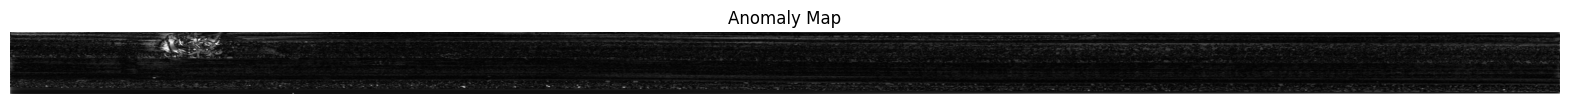

In [19]:

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(anomaly_map, cv2.COLOR_BGR2RGB))
plt.title("Anomaly Map")
plt.axis('off')

(-0.5, 9755.5, 389.5, -0.5)

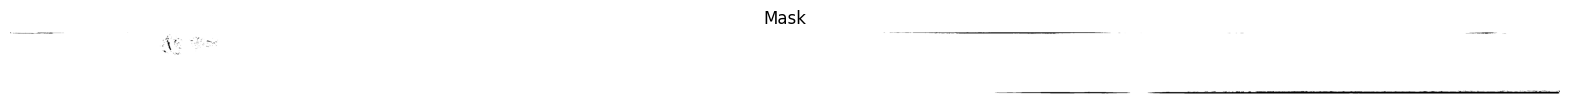

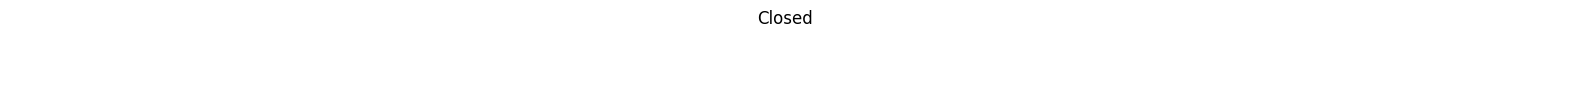

In [22]:
mask, closed, boxes = detect_defects(anomaly_map, red_percentile=80, area_thresh=200, merge_kernel_size=(30, 30))

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Mask")
plt.axis('off')

plt.figure(figsize=(20, 4))
plt.imshow(cv2.cvtColor(closed, cv2.COLOR_BGR2RGB))
plt.title("Closed")
plt.axis('off')







